In [1]:
#importing packages
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from Utility.IO import *


#### Load Dictionary

In [2]:
dic=load_dictionary()

In [6]:
cat_list0=dic.category.unique()
cat_list=np.delete(cat_list0,[0,8])
cat_list

array([u'school', u'admissions', u'academics', u'student', u'cost', u'aid',
       u'completion', u'earnings'], dtype=object)

#### Read data and transform

In [21]:
rpyrt0=get_rpyrt_by_class(1)

In [22]:
rpyrt=rpyrt0
y=rpyrt.RPY_1YR_RT
rpyrt.RPY_1YR_RT=np.log(y/(1-y))

#### Variable Screening

In [24]:
screen=prescreening_by_class(rpyrt,y=1,nobs=500)

In [25]:
dic=dic.loc[dic['name'].isin(screen),:]

In [26]:
X=rpyrt[screen].fillna(0)
print X.shape
X=X/X.std()
print X.shape

(35027, 500)
(35027, 500)


### PCA

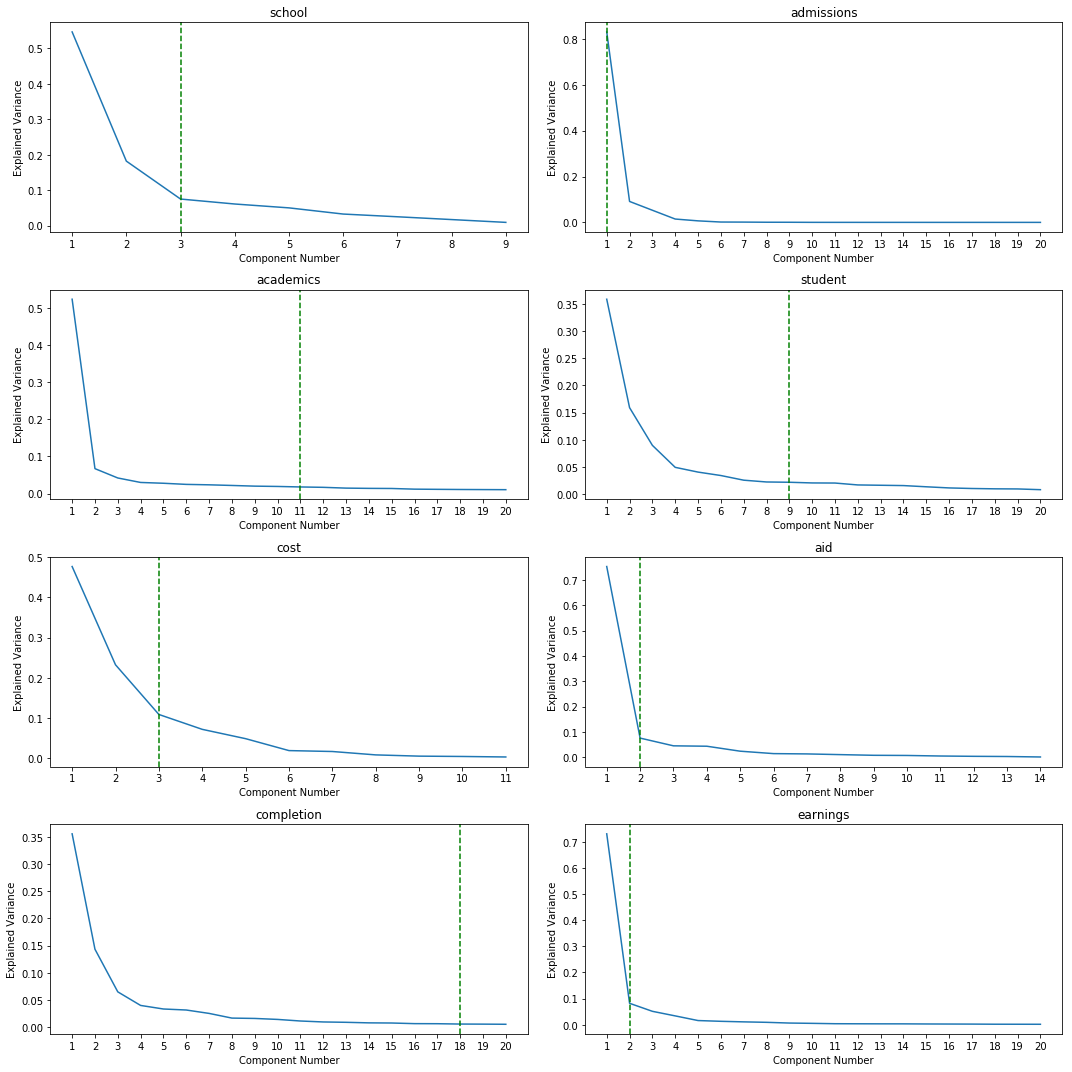

In [27]:
#pca = PCA(n_components=3)
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
ncom=[3,2,4,7,3,2,12,5]
i=0
for cat in cat_list:
    variables=dic.loc[dic.category==cat,'name']
    XX=X.loc[:,np.array(variables)].fillna(0)
    pca=PCA(n_components=min(XX.shape[1],20))
    pca.fit(XX)
    ax=axes[i/2,i%2]
    ax.plot(range(1,(pca.n_components_+1)),pca.explained_variance_ratio_,label="x")
    ax.set_xlabel('Component Number')
    ax.set_ylabel('Explained Variance')
    ax.set_xticks(range(1,(pca.n_components_+1)))
    ax.set_title(cat)
    ax.axvline(PCA(0.8).fit(XX).n_components_,linestyle='--',color='g')
    #ax.axvline(ncom[i],linestyle='--',color='g')
    i=i+1
plt.tight_layout()

### Linear Regression on PCA

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
import statsmodels.formula.api as smf
import math

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))


#pca = PCA(n_components=3)
var=0.8
X_trans=None
for cat in cat_list:
    variables=dic.loc[dic.category==cat,'name']
    XX=X.loc[:,np.array(variables)].fillna(0)
    pca=PCA(var)
    XX_trans=pca.fit_transform(XX)
    XX_trans=pd.DataFrame(XX_trans)
    X_trans=pd.concat([X_trans,XX_trans],axis=1)    
X_trans.shape
y=rpyrt.RPY_1YR_RT
model=LinearRegression()
model.fit(X_trans,y)
model.score(X_trans,y)
cv=cross_val_score(LinearRegression(), X_trans, y ,cv=10)
print cv.mean()
#val_train, val_test=validation_curve(LinearRegression(), X_trans, y, 'fit_intercept',[True],cv=10,scoring=rms_error)
#print val_train.mean()
#print val_test.mean()
X_trans.shape

0.781021919642


(35027, 49)

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
rf=RandomForestRegressor(10,oob_score = True).fit(X, y)

C:\Users\b_luo\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\ensemble\forest.py:720: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [41]:
rf.feature_importances_

array([  9.72010376e-04,   1.42043711e-01,   9.00913104e-03,
         4.88103897e-01,   9.01646849e-05,   4.32733839e-03,
         2.81339558e-02,   3.28885597e-03,   8.10405851e-05,
         2.12382103e-04,   2.62993205e-04,   2.74886482e-03,
         8.93808976e-03,   6.45670436e-04,   1.86102194e-04,
         3.84665576e-04,   6.78945865e-04,   2.50480922e-03,
         2.67976179e-04,   1.00467751e-03,   4.59680739e-04,
         1.69231898e-04,   4.82187478e-04,   1.38200122e-03,
         1.77282246e-03,   6.04839862e-05,   1.68957209e-04,
         2.75305887e-04,   2.01103174e-05,   1.75411238e-04,
         3.86244090e-05,   3.89199112e-05,   7.32736726e-05,
         2.88065700e-04,   4.92209500e-04,   4.05243109e-05,
         6.78801896e-03,   1.00599184e-04,   4.92749239e-05,
         6.74435512e-06,   1.56468695e-04,   4.64356071e-04,
         2.12674225e-04,   7.25574249e-04,   1.24528283e-04,
         2.17968626e-04,   1.44447659e-05,   7.80727767e-04,
         3.07331378e-04,

In [43]:
rf.n_features_

500L

In [36]:
help(rf)

Help on RandomForestRegressor in module sklearn.ensemble.forest object:

class RandomForestRegressor(ForestRegressor)
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and use averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="mse")
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion, and "mae" for the mean
 |      absolute